#**SUPERVISED**

#**Bussiness goal**
O objetivo é prever a classe de preço das propriedades com base em características como o número de quartos, banheiros, área útil e vizinhança. Isso visa otimizar a avaliação de casas, proporcionando uma maneira mais precisa e eficiente de estimar o valor de mercado de uma propriedade, auxiliando compradores, vendedores e investidores no processo de decisão.

#**Referencia do dataset utilizado**
O dataset utilizado está presente no seguinte link: https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data

#**Inicialização**

##**Importação de bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from google.colab import files

##**Importação do dataset**

In [2]:
import kagglehub

dataset_path = "muhammadbinimran/housing-price-prediction-data"
!kaggle datasets download {dataset_path} -p /content/ --unzip

Dataset URL: https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data
License(s): other
  0% 0.00/763k [00:00<?, ?B/s]
100% 763k/763k [00:00<00:00, 36.8MB/s]


##**Demonstração do conteudo do dataset**

In [3]:
housing_price_file = pd.read_csv('housing_price_dataset.csv')
housing_price_data = pd.DataFrame(housing_price_file)

housing_price_data.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


##**Dataset metadata**

| Coluna        | Tipo de Dado |
|---------------|--------------|
| SquareFeet    | int          |
| Bedrooms      | int          |
| Bathrooms     | int          |
| Neighborhood  | string       |
| YearBuilt     | int          |
| Price         | float        |


#**Data preparation e data selection**

##**Verificação de nulos**

In [4]:
housing_price_data.isna().sum()

,0
SquareFeet,0
Bedrooms,0
Bathrooms,0
Neighborhood,0
YearBuilt,0
Price,0


Não existe valores nulos

##**Verificação de duplicatas**

In [5]:
housing_price_data.duplicated().sum()

0

Não existe valores duplicados

##**Verificação dos valores**

Precisamos de verificar se existem valores que não fazem sentido no nosso contexto. Como por exemplo, a existencia de valores negativos.

In [6]:
numeric_columns = housing_price_data.select_dtypes(include=['number'])
negative_values = (numeric_columns < 0).sum()
print(negative_values)

SquareFeet     0
Bedrooms       0
Bathrooms      0
YearBuilt      0
Price         22
dtype: int64


Como existe preços negativos, temos de os tirar, pois nao faz sentido uma casa com valor negativo.

In [7]:
print(housing_price_data[housing_price_data['Price'] < 0].tail())
housing_price_data = housing_price_data[housing_price_data['Price'] >= 0].copy()
print("\nNegativos retirados...\n")
print(housing_price_data[housing_price_data['Price'] < 0].sum())

       SquareFeet  Bedrooms  Bathrooms Neighborhood  YearBuilt         Price
29827        1173         5          2        Rural       1988   -847.895073
30171        1066         3          1        Rural       1964   -602.209099
33666        1013         5          2        Urban       1960 -36588.165397
35553        1374         4          3        Urban       1996  -4771.570194
36929        1078         5          1       Suburb       2015  -6159.039213

Negativos retirados...

SquareFeet        0
Bedrooms          0
Bathrooms         0
Neighborhood      0
YearBuilt         0
Price           0.0
dtype: object


##**Criação das categorias**

Para a classificação das casas, foi seleciona o uso de 3 classes perante o preço. Classe **Baixa**, abaixo ou igual a 60000, classe **Média**, entre 60000 e 400000, e classe **Alta**, acima de 400000.

In [8]:
#criar categorias de preço
housing_price_data.loc[housing_price_data['Price'] <= 60000, 'PriceCategory'] = 'Baixo'
housing_price_data.loc[(housing_price_data['Price'] > 60000) & (housing_price_data['Price'] <= 400000), 'PriceCategory'] = 'Médio'
housing_price_data.loc[housing_price_data['Price'] > 400000, 'PriceCategory'] = 'Alto'

#**EDA Visualização**

##**Matriz de correlação**
A matriz de correlação é uma ferramenta estatística que mede a relação entre diferentes variáveis. Ela exibe valores entre -1 e 1, onde 1 significa uma correlação positiva perfeita, -1 uma correlação negativa perfeita e 0 indica nenhuma correlação. Essa matriz é útil para entender como as variáveis estão interligadas, ajudando a identificar padrões e a selecionar as variáveis mais relevantes.

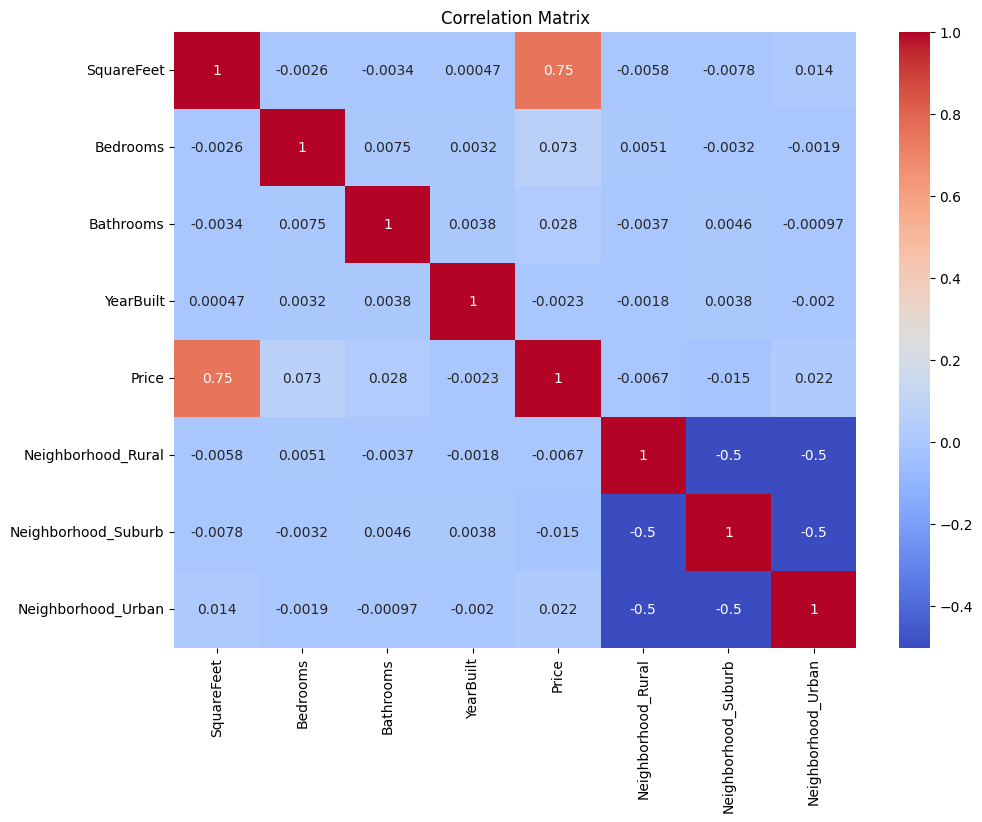

In [9]:
plt.figure(figsize=(11, 8))

housing_price_data =  pd.get_dummies(housing_price_data, columns=['Neighborhood'])
housing_price_correlation = housing_price_data.drop(columns=['PriceCategory'])

sns.heatmap(housing_price_correlation.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Com esta matriz, podemos ver que perante o **Price**, a *feature* utilizada para classe, o **Squarefeet** tem relação forte e os restantes tem relação muito fraca.

##**Diagrama de caixa**

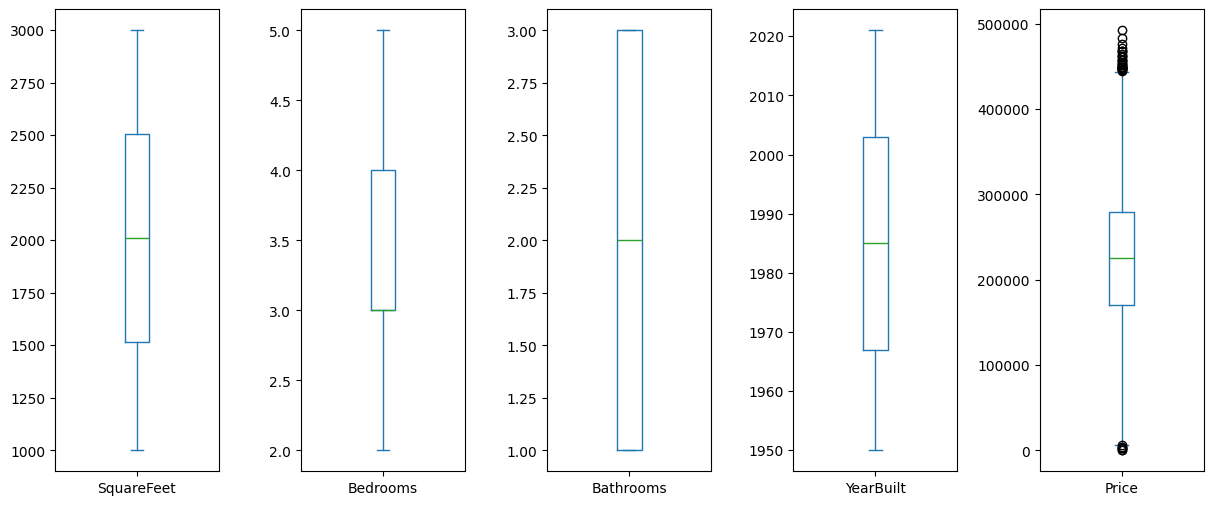

In [10]:
housing_price_data.plot(kind='box', subplots=True, layout=(1, 6), sharex=False, sharey=False, figsize=(18, 6))
plt.subplots_adjust(wspace=0.5)
plt.show()

Os diagramas de caixa mostram que a maioria das casas possui entre 1500 e 2500 pés quadrados, com uma mediana em torno de 2000. O número de quartos geralmente varia de 3 a 4, e a maior parte das propriedades tem 2 banheiros. As casas foram construídas principalmente entre 1970 e 2000, com uma mediana em 1985. O preço das casas apresenta uma distribuição assimétrica, com alguns *outliers* elevados, mas a maior concentração de preços está entre 175.000 e 275.000 unidades monetárias.

##**Remoção do Price**

Removemos o **Price** dos dados.

In [11]:
if 'Price' in housing_price_data.columns:
    housing_price_data = housing_price_data.drop(columns=['Price'])

##**Peso das classes**

In [12]:
print(housing_price_data['PriceCategory'].value_counts())

PriceCategory
Médio    49105
Baixo      534
Alto       339
Name: count, dtype: int64


A classe **Média** tem um número maior que os outros, o que gera um desbalanceamento entre classes, o que poderá levar aos modelos classificarem mais vezes **Médio** do que deviam.

In [13]:

medium_class = housing_price_data[housing_price_data['PriceCategory'] == 'Médio']
other_classes = housing_price_data[housing_price_data['PriceCategory'] != 'Médio']

medium_class_reduced = medium_class.sample(frac=0.01, random_state=27)

housing_price_data = pd.concat([medium_class_reduced, other_classes])

housing_price_data = housing_price_data.sample(frac=1, random_state=27).reset_index(drop=True)

print(housing_price_data['PriceCategory'].value_counts())

PriceCategory
Baixo    534
Médio    491
Alto     339
Name: count, dtype: int64


Agora as classes estão equilibradas.

##**Visualização 2D dos dados**

In [14]:
#sns.pairplot(housing_price_data, hue='PriceCategory')
#plt.show()

#**Método DecisionTreeClassifier**

##**Model building**

Para selecionar os dados utilizou-se o hold-out para dividir os dados de treino e teste.

In [15]:
X = housing_price_data.drop(columns=['PriceCategory'])

y = housing_price_data['PriceCategory']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

model = DecisionTreeClassifier(max_depth=3, random_state=25)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=25)

###**Visualização da árvore**

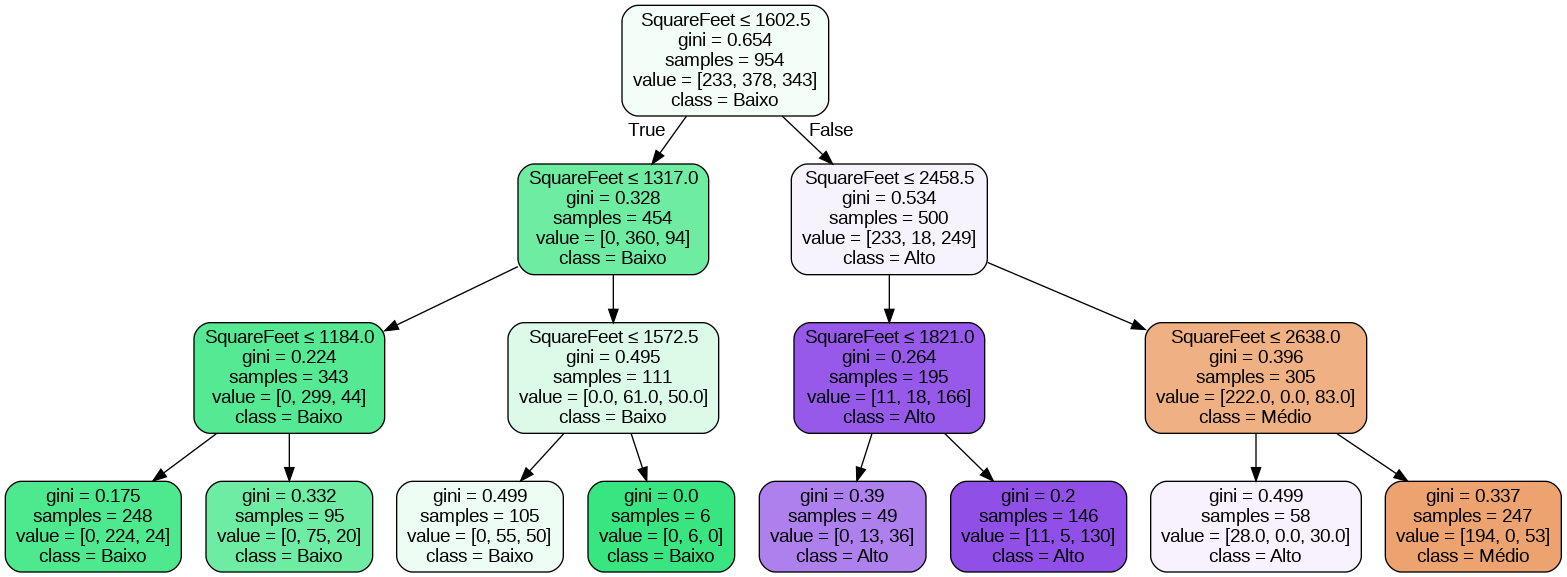

In [16]:
dot_data = tree.export_graphviz(model,
                           feature_names=X.columns,
                           class_names=y.unique(),
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png", cleanup=True)

Image("decision_tree.png", height=600)

##**Model assessment**

Accuracy: 0.802439024390244
              precision    recall  f1-score   support

        Alto       0.83      0.81      0.82       106
       Baixo       0.80      0.96      0.87       156
       Médio       0.78      0.63      0.70       148

    accuracy                           0.80       410
   macro avg       0.80      0.80      0.80       410
weighted avg       0.80      0.80      0.80       410



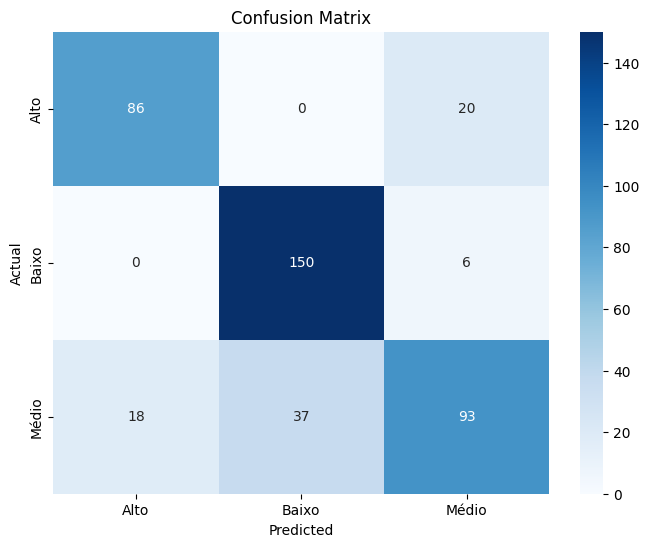

In [17]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

A matriz de confusão e as métricas de desempenho do modelo DecisionTreeClassifier indicam uma acurácia de aproximadamente 80%. O modelo apresenta um bom desempenho nas categorias **Alto** e **Baixo**, com **F1-scores** de 0.82 para **Alto** e 0.87 para **Baixo**, mas enfrenta dificuldades na classificação da categoria **Médio**, que possui um **F1-score** de 0.70 e **recall** de 0.63. Isso reflete uma confusão entre as classes, com muitos casos da categoria **Médio** sendo classificados incorretamente como **Alto** ou **Baixo**. A sobreposição das características entre as classes, evidenciada pelos gráficos presentes no "Visualização 2D dos dados", parece ser um fator contribuinte. Features como **Bedrooms**, **Bathrooms**, **YearBuilt** e **Neighborhood** mostram sobreposição, o que pode dificultar a distinção clara entre as classes pelo modelo.

##**Melhores parametros**

In [ ]:
param_grid = {
    'max_depth': [1,2,3,4,5,10],
    'min_samples_split': [2,5,6,7,8],
    'min_samples_leaf': [2,3,4,5,8,9,10],
}

grid_search = GridSearchCV(model, param_grid ,scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

O modelo com parâmetros {'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2} teve desempenho inferior ao modelo inicial com {'max_depth': 3} porque a restrições nas folhas resultaram em um modelo menos flexível, incapaz de capturar padrões. Isso levou a uma *accuracy* mais baixa, indicando que a configuração inicial estava melhor perante o conjunto de dados.

#**Método k-nearest neighbors**

##**Model Building**

Outra vez, utilizou-se o metodo hold-out.

In [ ]:
X = housing_price_data.drop(columns=['PriceCategory'])
y = housing_price_data['PriceCategory']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_knn = KNeighborsClassifier(n_neighbors=4,metric = 'euclidean', weights = 'uniform')
model_knn.fit(X_train_scaled, y_train)

###**Visualização do Knn**

A visualização do modelo do Knn é realizada através da demonstração da distancia de k com os seus vizinhos. Ajuda para visualizar se existe ruído nos dados.

In [ ]:
distances, indices = model_knn.kneighbors(X_test_scaled)

plt.figure(figsize=(50, 8))

for i in range(distances.shape[1]):
    plt.plot(distances[:, i], label=f'Distância para o {i+1}º vizinho mais próximo')

for y in np.arange(0, max(distances.flatten()), 0.2):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

plt.title('Distâncias para os vizinhos mais próximos no modelo K-NN')
plt.xlabel('Índice do ponto de teste')
plt.ylabel('Distância')

plt.legend()

plt.show()


O gráfico mostra as distâncias dos 4 vizinhos mais próximos para cada ponto de teste no modelo KNN. As distâncias aumentam gradualmente do 1º vizinho (linha azul) até o 4º (linha vermelha), com algumas variações e picos ocasionais. Isso sugere que os dados estão bem distribuídos, mas também pode haver sobreposição entre as classes.

##**Model assessment**

In [ ]:
y_pred = model_knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

O modelo apresenta uma accuracy de 71%, com um bom desempenho nas categorias Alto e Baixo, ambas com **f1-scores** de 0.76 e 0.84, e **recalls** de 0.85 e 0.97, respectivamente. A categoria **Médio**, no entanto, continua com má performance, com um **f1-score** de 0.46 e **recall** baixo de 0.34, indicando que menos de um terço dos casos Médio são classificados corretamente. A matriz revela que o modelo classificou corretamente 106 casos **Alto**, 156 casos **Baixo**, e apenas 50 casos **Médio**, com erros distribuídos entre **Alto** (37 casos) e **Baixo** (51 casos). Isso sugere uma sobreposição significativa da classe Médio com as outras. Isso sugere novamente uma sobreposição entre as classes, já que o modelo tem dificuldade em distinguí-las.

##**Melhores parametros**

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto','ball_tree', 'kd_tree']
}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid_knn, scoring='accuracy')

grid_search_knn.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Best accuracy: {grid_search_knn.best_score_}")

A melhor performance do modelo Knn com esses parâmetros ocorre porque o n_neighbors: 10 permite comparar com mais vizinhos, permitindo distinguir melhor as classes, e weights: uniform permite que todos os vizinhos tenham o mesmo peso na decisão.

#**Naive Bayes**

##**Model Building**

Utilizou-se os mesmo training sets do Knn

In [ ]:
model_nb = GaussianNB()
model_nb.fit(X_train_scaled, y_train)

###**Visualização do Naive Bayes**

In [ ]:
probs = model_nb.predict_proba(X_test_scaled)

plt.figure(figsize=(50, 8))

# Plotando as probabilidades para cada classe
for i in range(probs.shape[1]):
    plt.plot(probs[:, i], label=f'Probabilidade para a classe {model_nb.classes_[i]}')


for y in np.arange(0, 1.1, 0.2):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Título e labels
plt.title('Probabilidades preditas para cada classe (Naive Bayes)')
plt.xlabel('Índice do ponto de teste')
plt.ylabel('Probabilidade')

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()


##**Model assessment**

In [ ]:
y_pred = model_nb.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


O modelo Naive Bayes alcançou uma accuracy de 79%, superando o Knn mas não o DecisionTree. Ele teve bom desempenho nas categorias **Alto** e **Baixo** (**f1-scores** de 0.83 e 0.87) e melhorou a classificação da categoria Médio (**f1-score** de 0.65), embora ainda tenha dificuldades, com um **recall** de 0.53.

##**Melhores parametros**

In [ ]:
param_grid_nb = {
    'var_smoothing': [
        1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6,
        1e-5, 1e-4,1e-3,9e-2,8e-2,1e-2,2e-1 ,1e-1,0, 0.5, 1, 2, 5, 10, 15, 20, 25, 50,
        100, 200, 500, 1000, 5000, 10000
    ]
}

nb = GaussianNB()

grid_search_nb = GridSearchCV(nb, param_grid_nb, scoring='accuracy')

grid_search_nb.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search_nb.best_params_}")
print(f"Best accuracy: {grid_search_nb.best_score_}")

O modelo inicial já estava bem ajustado com o valor padrão de var_smoothing, e a busca por novos parâmetros não gerou melhorias significativas, pois a suavização adicional não teve impacto relevante no desempenho para este conjunto de dados. Isso pode indicar que o modelo não necessita de ajustes tão finos para alcançar uma boa performance.